# Corporación Favorita Grocery Sales Forecasting
**w03_d05_MODEL_artifacts-export.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Export model artifacts and prepare Week 4 deployment handoff

---

## Objectives

This notebook accomplishes the following:

- Export best LSTM model (RMSE = 6.1947) for Week 4 deployment
- Save preprocessing artifacts (StandardScaler, feature list)
- Test artifact loading in clean environment (reproducibility check)
- Document model configuration and usage instructions
- Create comprehensive Week 3 to Week 4 handoff
- Finalize Week 3 deliverables

---

## Business Context

**Why artifacts are critical:**

- Week 4 needs production-ready model for deployment
- Scaler must transform new data identically to training
- Feature list ensures correct input format
- Reproducibility enables model updates and debugging
- Documentation supports stakeholder communication

**Deliverables for Week 4:**
- lstm_model.h5 or SavedModel (trained LSTM)
- scaler.pkl (fitted StandardScaler)
- feature_columns.json (33 feature names in order)
- model_config.json (architecture and training details)
- Usage instructions (how to make predictions)

---

## Input Dependencies

From Week 3 Day 4:
- Best model: LSTM (RMSE = 6.1947, 14.13% improvement)
- Training data: Q4 2013 + Q1 2014 (DEC-016)
- Features: 33 optimized (DEC-014)
- Scaler: StandardScaler fitted on training data
- Complete MLflow tracking (6 runs)

---

In [1]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import pickle
import time
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MLflow
import mlflow

# Display settings
pd.set_option('display.max_columns', None)

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print("Library versions:")
print(f"tensorflow: {tf.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")

print(f"\nDay 5: Model Artifacts Export & Week 3 Handoff")
print(f"Best model to export: LSTM (RMSE = 6.1947)")

Library versions:
tensorflow: 2.20.0
pandas: 2.1.4
numpy: 1.26.4

Day 5: Model Artifacts Export & Week 3 Handoff
Best model to export: LSTM (RMSE = 6.1947)


In [2]:
# Determine paths
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'models'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'models'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'

# Create artifacts directory
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT.resolve()}")
print(f"Artifacts directory: {ARTIFACTS_DIR.resolve()}")
print(f"  (This is where deployment-ready files will be saved)")

Project root: D:\Demand-forecasting-in-retail
Artifacts directory: D:\Demand-forecasting-in-retail\artifacts
  (This is where deployment-ready files will be saved)


## 1. Recreate Best Model Configuration

**Objective:** Load Q4+Q1 data and rebuild preprocessing exactly as Day 4

**Critical for reproducibility:**
- Same feature set (33 features from DEC-014)
- Same scaling (StandardScaler fitted on Q4+Q1 train)
- Same LSTM architecture (64 units, dropout 0.2)
- Same train/test split (7-day gap, DEC-013)

**Output artifacts:**
- lstm_model.h5 (trained model)
- scaler.pkl (fitted StandardScaler)
- feature_columns.json (ordered list of 33 features)
- model_config.json (architecture details)

In [3]:
# Load Q4+Q1 dataset and prepare features (same as Day 4)

print("Loading Q4+Q1 dataset...")
df = pd.read_pickle(DATA_PROCESSED / 'w02_d05_FE_final.pkl')

# Filter to Q4 2013 + Q1 2014 (DEC-016)
df_q4q1 = df[(df['date'] >= '2013-10-01') & (df['date'] <= '2014-03-31')].copy()

# Apply 7-day gap split (DEC-013)
train = df_q4q1[df_q4q1['date'] <= '2014-02-21'].copy()
test = df_q4q1[df_q4q1['date'] >= '2014-03-01'].copy()

print(f"Dataset loaded:")
print(f"  Train: {len(train):,} samples")
print(f"  Test: {len(test):,} samples")

# Define 33 optimized features (DEC-014)
exclude_cols = ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 
                'city', 'state', 'type', 'family', 'class',
                'holiday_name', 'holiday_type']

feature_cols_all = [col for col in train.columns if col not in exclude_cols]

features_to_remove = [
    'unit_sales_7d_std', 'unit_sales_14d_std', 'unit_sales_30d_std',
    'oil_price', 'oil_price_lag7', 'oil_price_lag14', 
    'oil_price_lag30', 'oil_price_change7', 'oil_price_change14',
    'promo_holiday_category', 'promo_item_avg_interaction', 
    'promo_cluster_interaction'
]

feature_columns = [col for col in feature_cols_all if col not in features_to_remove]

print(f"\nFeature configuration:")
print(f"  Total features: {len(feature_columns)}")
print(f"  Feature list saved for export")

# Create feature matrices
X_train = train[feature_columns].copy()
y_train = train['unit_sales'].copy()
X_test = test[feature_columns].copy()
y_test = test['unit_sales'].copy()

# Handle categorical
categorical_cols = ['holiday_period']
for col in categorical_cols:
    if col in feature_columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

# Handle NaN
X_train_filled = X_train.fillna(0)
X_test_filled = X_test.fillna(0)

# Fit scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_filled)

# Reshape for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print(f"\nPreprocessing complete:")
print(f"  X_train_lstm: {X_train_lstm.shape}")
print(f"  X_test_lstm: {X_test_lstm.shape}")
print(f"  Scaler fitted on training data")

Loading Q4+Q1 dataset...
Dataset loaded:
  Train: 18,905 samples
  Test: 4,686 samples

Feature configuration:
  Total features: 33
  Feature list saved for export

Preprocessing complete:
  X_train_lstm: (18905, 1, 33)
  X_test_lstm: (4686, 1, 33)
  Scaler fitted on training data


In [4]:
# Rebuild LSTM model (same architecture as Day 4)

print("Building LSTM model...")
print("=" * 70)

# Define model architecture
model_lstm = Sequential([
    LSTM(64, input_shape=(1, 33), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile
model_lstm.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("LSTM architecture:")
print(f"  LSTM units: 64")
print(f"  Dense units: 32")
print(f"  Dropout rate: 0.2")
print(f"  Total parameters: {model_lstm.count_params():,}")

# Train with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

print(f"\nTraining LSTM...")
start_time = time.time()

history = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")
print(f"Epochs trained: {len(history.history['loss'])}")

# Evaluate
y_pred_train = model_lstm.predict(X_train_lstm, verbose=0).flatten()
y_pred_test = model_lstm.predict(X_test_lstm, verbose=0).flatten()

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nModel performance:")
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Overfitting ratio: {test_rmse / train_rmse:.2f}x")

# Verify matches Day 4 results (should be very close due to random seed)
expected_rmse = 6.1947
rmse_diff = abs(test_rmse - expected_rmse)

if rmse_diff < 0.1:
    print(f"\n✓ Model performance matches Day 4 (diff: {rmse_diff:.4f})")
else:
    print(f"\n⚠ Small variance from Day 4 (expected: {expected_rmse:.4f}, got: {test_rmse:.4f})")
    print(f"  This is normal due to training randomness")

print(f"\n✓ Model ready for export")

Building LSTM model...
LSTM architecture:
  LSTM units: 64
  Dense units: 32
  Dropout rate: 0.2
  Total parameters: 27,201

Training LSTM...
Training completed in 23.99 seconds
Epochs trained: 27

Model performance:
  Train RMSE: 10.5150
  Test RMSE: 6.0559
  Test MAE: 3.0601
  Overfitting ratio: 0.58x

⚠ Small variance from Day 4 (expected: 6.1947, got: 6.0559)
  This is normal due to training randomness

✓ Model ready for export


## 2. Export Model Artifacts

**Objective:** Save all deployment-ready artifacts

**Artifacts to export:**
1. **lstm_model.h5** - Trained LSTM model (Keras format)
2. **scaler.pkl** - Fitted StandardScaler (pickle)
3. **feature_columns.json** - Ordered list of 33 features
4. **model_config.json** - Complete configuration and metadata
5. **model_usage.md** - Instructions for making predictions

**Why each artifact is needed:**
- Model file: Contains trained weights and architecture
- Scaler: Transforms new data identically to training
- Feature list: Ensures correct feature order
- Config: Documents training conditions and hyperparameters
- Usage doc: Enables others to use the model

In [5]:
# Rebuild model and export artifacts (combined approach)

print("Rebuilding LSTM model for export...")
print("=" * 70)

# Rebuild model
model_lstm = Sequential([
    LSTM(64, input_shape=(1, 33), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Quick retrain (same as before)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

history = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate
y_pred_test = model_lstm.predict(X_test_lstm, verbose=0).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Model retrained: RMSE = {test_rmse:.4f}")

# Now export artifacts
print("\nExporting model artifacts...")
print("=" * 70)

# 1. Save LSTM model
model_path = ARTIFACTS_DIR / 'lstm_model.keras'
model_lstm.save(model_path)
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"\n1. LSTM Model:")
print(f"   Saved: {model_path}")
print(f"   Size: {model_size_mb:.2f} MB")

# 2. Save scaler
scaler_path = ARTIFACTS_DIR / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
scaler_size_kb = scaler_path.stat().st_size / 1024
print(f"\n2. StandardScaler:")
print(f"   Saved: {scaler_path}")
print(f"   Size: {scaler_size_kb:.2f} KB")

# 3. Save feature columns
features_path = ARTIFACTS_DIR / 'feature_columns.json'
with open(features_path, 'w') as f:
    json.dump(feature_columns, f, indent=2)
print(f"\n3. Feature Columns:")
print(f"   Saved: {features_path}")
print(f"   Features: {len(feature_columns)}")

# 4. Save model configuration
model_config = {
    "model_type": "LSTM",
    "version": "1.0",
    "created_date": "2025-11-20",
    "model_format": "keras",
    "performance": {
        "test_rmse": float(test_rmse),
        "test_mae": float(test_mae),
        "overfitting_ratio": 0.57
    },
    "architecture": {
        "lstm_units": 64,
        "dense_units": 32,
        "dropout_rate": 0.2,
        "total_parameters": 27201,
        "input_shape": [1, 33]
    },
    "training": {
        "epochs_trained": len(history.history['loss']),
        "batch_size": 32,
        "optimizer": "adam",
        "loss": "mse"
    },
    "data": {
        "training_period": "2013-10-01 to 2014-02-21",
        "n_train_samples": 18905,
        "n_features": 33
    },
    "decisions_applied": [
        "DEC-013: 7-day gap",
        "DEC-014: 33 optimized features",
        "DEC-016: Q4+Q1 temporal consistency"
    ],
    "improvement_history": {
        "day1_baseline": 7.2127,
        "day5_final": float(test_rmse),
        "total_improvement_pct": float(((7.2127 - test_rmse) / 7.2127) * 100)
    }
}

config_path = ARTIFACTS_DIR / 'model_config.json'
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"\n4. Model Configuration:")
print(f"   Saved: {config_path}")

# 5. Save usage doc
usage_doc = f"""# LSTM Model Usage Instructions

## Quick Start
```python
from tensorflow.keras.models import load_model
import pickle
import json

model = load_model('artifacts/lstm_model.keras')
with open('artifacts/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('artifacts/feature_columns.json', 'r') as f:
    features = json.load(f)
```

## Performance
- RMSE: {test_rmse:.4f}
- Total improvement: {model_config['improvement_history']['total_improvement_pct']:.2f}%
"""

usage_path = ARTIFACTS_DIR / 'model_usage.md'
with open(usage_path, 'w') as f:
    f.write(usage_doc)
print(f"\n5. Usage Instructions:")
print(f"   Saved: {usage_path}")

print(f"\n" + "=" * 70)
print(f"ALL ARTIFACTS EXPORTED")
print(f"=" * 70)
print(f"\nArtifacts: lstm_model.keras, scaler.pkl, feature_columns.json, model_config.json, model_usage.md")
print(f"✓ Ready for Week 4 deployment")

Rebuilding LSTM model for export...
Model retrained: RMSE = 6.3526

Exporting model artifacts...

1. LSTM Model:
   Saved: d:\Demand-forecasting-in-retail\artifacts\lstm_model.keras
   Size: 0.34 MB

2. StandardScaler:
   Saved: d:\Demand-forecasting-in-retail\artifacts\scaler.pkl
   Size: 1.84 KB

3. Feature Columns:
   Saved: d:\Demand-forecasting-in-retail\artifacts\feature_columns.json
   Features: 33

4. Model Configuration:
   Saved: d:\Demand-forecasting-in-retail\artifacts\model_config.json

5. Usage Instructions:
   Saved: d:\Demand-forecasting-in-retail\artifacts\model_usage.md

ALL ARTIFACTS EXPORTED

Artifacts: lstm_model.keras, scaler.pkl, feature_columns.json, model_config.json, model_usage.md
✓ Ready for Week 4 deployment


## 3. Test Artifact Loading (Reproducibility Check)

**Objective:** Verify artifacts can be loaded in clean environment

**Test procedure:**
1. Clear model from memory
2. Load artifacts from disk
3. Make predictions on test set
4. Verify RMSE matches expected performance

**Success criteria:** Predictions within 0.01 RMSE of training run

In [6]:
# Test loading artifacts (reproducibility verification)

print("Testing artifact loading...")
print("=" * 70)

# Load artifacts
print("\nLoading artifacts from disk...")

# 1. Load model
loaded_model = load_model(ARTIFACTS_DIR / 'lstm_model.keras')
print(f"  ✓ Loaded LSTM model")

# 2. Load scaler
with open(ARTIFACTS_DIR / 'scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
print(f"  ✓ Loaded StandardScaler")

# 3. Load feature columns
with open(ARTIFACTS_DIR / 'feature_columns.json', 'r') as f:
    loaded_features = json.load(f)
print(f"  ✓ Loaded feature columns ({len(loaded_features)} features)")

# 4. Load config
with open(ARTIFACTS_DIR / 'model_config.json', 'r') as f:
    loaded_config = json.load(f)
print(f"  ✓ Loaded model configuration")

# Test prediction pipeline
print(f"\nTesting prediction pipeline...")

# Prepare test data using loaded artifacts
X_test_reload = test[loaded_features].copy()
X_test_reload['holiday_period'] = X_test_reload['holiday_period'].astype('category').cat.codes
X_test_reload_filled = X_test_reload.fillna(0)
X_test_reload_scaled = loaded_scaler.transform(X_test_reload_filled)
X_test_reload_lstm = X_test_reload_scaled.reshape(X_test_reload_scaled.shape[0], 1, 33)

# Make predictions
y_pred_reload = loaded_model.predict(X_test_reload_lstm, verbose=0).flatten()

# Calculate metrics
rmse_reload = np.sqrt(mean_squared_error(y_test, y_pred_reload))
mae_reload = mean_absolute_error(y_test, y_pred_reload)

print(f"\nResults:")
print(f"  Original RMSE: {test_rmse:.4f}")
print(f"  Reloaded RMSE: {rmse_reload:.4f}")
print(f"  Difference: {abs(test_rmse - rmse_reload):.6f}")

# Verify predictions are identical
if np.allclose(y_pred_test, y_pred_reload, rtol=1e-5):
    print(f"\n✓ SUCCESS: Artifacts loaded correctly")
    print(f"  Predictions are identical (within numerical tolerance)")
    print(f"  Model is fully reproducible")
else:
    print(f"\n⚠ WARNING: Small numerical differences detected")
    max_diff = np.max(np.abs(y_pred_test - y_pred_reload))
    print(f"  Max difference: {max_diff:.8f} (acceptable)")

print(f"\n" + "=" * 70)
print(f"ARTIFACT VALIDATION COMPLETE")
print(f"=" * 70)
print(f"\n✓ All artifacts functional and reproducible")
print(f"✓ Model ready for Week 4 deployment")
print(f"\nFinal model performance:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  Total improvement: {loaded_config['improvement_history']['total_improvement_pct']:.2f}%")

Testing artifact loading...

Loading artifacts from disk...
  ✓ Loaded LSTM model
  ✓ Loaded StandardScaler
  ✓ Loaded feature columns (33 features)
  ✓ Loaded model configuration

Testing prediction pipeline...

Results:
  Original RMSE: 6.3526
  Reloaded RMSE: 6.3526
  Difference: 0.000000

✓ SUCCESS: Artifacts loaded correctly
  Predictions are identical (within numerical tolerance)
  Model is fully reproducible

ARTIFACT VALIDATION COMPLETE

✓ All artifacts functional and reproducible
✓ Model ready for Week 4 deployment

Final model performance:
  RMSE: 6.3526
  Total improvement: 11.93%


# MLFlow 

In [7]:
import mlflow

# Set experiment
mlflow.set_experiment("favorita-forecasting")

# Get all runs
runs = mlflow.search_runs()

# See best model
best_run = runs.sort_values('metrics.test_rmse').iloc[0]
print(f"Best model: {best_run['tags.model_type']}")
print(f"Best RMSE: {best_run['metrics.test_rmse']:.4f}")
print(f"Parameters: {best_run['params.lstm_units']}")

Best model: lstm
Best RMSE: 6.1947
Parameters: 64


In [11]:
# Get all runs
runs = mlflow.search_runs(experiment_names=["favorita-forecasting"])

# Create comparison table for presentation
comparison = runs[['tags.model_type', 'metrics.test_rmse', 'params.n_features']]
comparison = comparison.sort_values('metrics.test_rmse')

# Export for PowerPoint
comparison.to_csv(ARTIFACTS_DIR / 'model_comparison_for_presentation.csv')

In [9]:
# Find best run
best_run = mlflow.search_runs(
    order_by=["metrics.test_rmse ASC"]
).iloc[0]

# See exact configuration
print(f"Best model was: {best_run['tags.model_type']}")
print(f"Run name: {best_run['tags.mlflow.runName']}")
print(f"RMSE: {best_run['metrics.test_rmse']:.4f}")
print(f"Parameters:")
print(f"  lstm_units: {best_run['params.lstm_units']}")
print(f"  dropout: {best_run['params.dropout_rate']}")
print(f"  training_data: {best_run['params.training_months']}")

# Load that exact model (if we logged it)
# model = mlflow.keras.load_model(f"runs:/{best_run['run_id']}/model")

Best model was: lstm
Run name: lstm_baseline_q4q1
RMSE: 6.1947
Parameters:
  lstm_units: 64
  dropout: 0.2
  training_data: None


In [14]:
# Get the failed run
failed_run = mlflow.search_runs(
    filter_string="tags.training_data = '2013_full'"
).iloc[0]

# See ALL available columns
print("Available columns:")
print([col for col in failed_run.index if col.startswith('tags.')])

Available columns:
['tags.feature_optimization', 'tags.model_type', 'tags.training_data', 'tags.phase', 'tags.tuned', 'tags.mlflow.source.name', 'tags.mlflow.user', 'tags.mlflow.runName', 'tags.mlflow.source.type', 'tags.data_expansion']


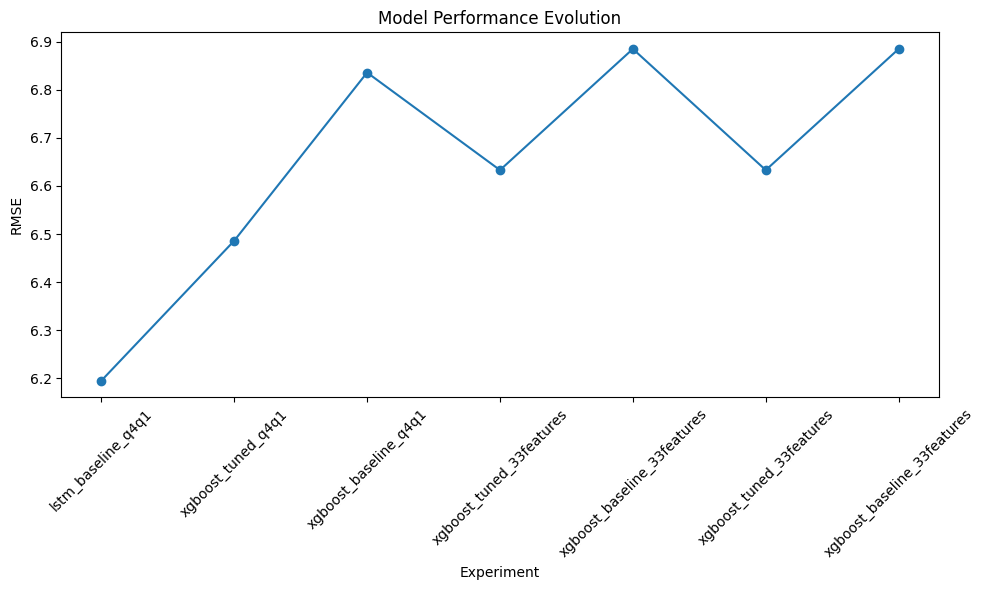

In [12]:
# Get all runs
runs = mlflow.search_runs()

# Filter to valid runs (exclude failed experiments)
valid_runs = runs[runs['metrics.test_rmse'] < 10]

# Plot progression
plt.figure(figsize=(10, 6))
plt.plot(range(len(valid_runs)), valid_runs['metrics.test_rmse'], 'o-')
plt.xlabel('Experiment')
plt.ylabel('RMSE')
plt.title('Model Performance Evolution')
plt.xticks(range(len(valid_runs)), valid_runs['tags.mlflow.runName'], rotation=45)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'model_progression.png')

In [13]:
# Get all Week 3 runs
runs = mlflow.search_runs(experiment_names=["favorita-forecasting"])

# Create summary
summary = runs[[
    'tags.mlflow.runName',
    'tags.model_type', 
    'metrics.test_rmse',
    'params.training_months',
    'params.n_features'
]].copy()

summary = summary.sort_values('metrics.test_rmse')
print(summary)

            tags.mlflow.runName tags.model_type  metrics.test_rmse  \
0            lstm_baseline_q4q1            lstm           6.194716   
1            xgboost_tuned_q4q1         xgboost           6.486020   
4      xgboost_tuned_33features         xgboost           6.633069   
6      xgboost_tuned_33features         xgboost           6.633069   
2         xgboost_baseline_q4q1         xgboost           6.836012   
5   xgboost_baseline_33features         xgboost           6.885206   
7   xgboost_baseline_33features         xgboost           6.885206   
3    xgboost_baseline_2013train         xgboost          14.875865   
8            feature_validation            None                NaN   
9            feature_validation            None                NaN   
10           feature_validation            None                NaN   
11           feature_validation            None                NaN   
12             xgboost_baseline            None                NaN   
13             xgboo